# Pipeline for breast cancer determinations

---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score, roc_curve, confusion_matrix, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import VotingClassifier

## 1. Reading the data

Import the biological dataset containing data on the concentration of cytokines in the blood

In [2]:
# Load dataset
data = pd.read_csv('Cytokines.csv', delimiter=',')
# Data preview
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Diagnosis  177 non-null    object 
 1   IL6        177 non-null    float64
 2   IL8        177 non-null    int64  
 3   IL10       177 non-null    float64
 4   IL17       177 non-null    float64
 5   IL18       177 non-null    float64
 6   IL1b       177 non-null    float64
 7   TNFa       177 non-null    float64
 8   IFNg       177 non-null    float64
 9   GCSF       177 non-null    float64
 10  GMCSF      177 non-null    float64
 11  VEGF       177 non-null    float64
 12  MCP1       177 non-null    float64
dtypes: float64(11), int64(1), object(1)
memory usage: 18.1+ KB


In [3]:
data.head()

,Diagnosis,IL6,IL8,IL10,IL17,IL18,IL1b,TNFa,IFNg,GCSF,GMCSF,VEGF,MCP1
0,Benign,5.0,185,1.0,2.0,12.4,16.9,1.9,2.0,2.0,2.0,11.0,589.2
1,Benign,8.6,166,4.6,1.0,35.8,14.5,1.0,23.2,8.4,2.0,104.1,2373.2
2,Benign,12.3,116,2.8,1.0,33.2,2.6,1.0,5.0,2.0,2.0,21.8,349.8
3,Benign,13.9,113,1.0,1.0,21.7,2.6,1.0,2.0,2.0,2.0,44.9,485.1
4,Cancer,182.7,472,13.0,1.0,54.4,42.7,1.0,5.0,34.5,2.0,92.0,187.5


The dataset contains the following columns:

* **Diagnosis (target)** — patient's diagnosis is breast cancer (**Cancer**) or benign breast disease (**Benign**).

Blood cytokine concentrations in pg/ml:
* IL6 — Interleukin 6;
* IL8 — Interleukin 8;
* IL10 — Interleukin 10;
* IL17 — Interleukin 17;
* IL18 — Interleukin 18;
* IL1b — Interleukin 1 beta;
* TNFa — Tumor Necrosis Factor alpha;
* IFNg — Interferon gamma;
* GMSF	— Granulocyte colony-stimulating factor;
* GMCSF — Granulocyte-macrophage colony-stimulating factor;
* VEGF — Vascular endothelial growth factor;
* MCP1 — Monocyte chemoattractant protein 1.

## 2. Data preprocessing

In [4]:
# Convert Diagnosis to binary values: 0 — Benign, 1 - Cancer
data['Diagnosis'] = data['Diagnosis'].apply(lambda x: 0 if str(x).strip().lower() == 'benign' else 1)
print(data['Diagnosis'].value_counts())

Diagnosis
1    130
0     47
Name: count, dtype: int64


<Axes: >

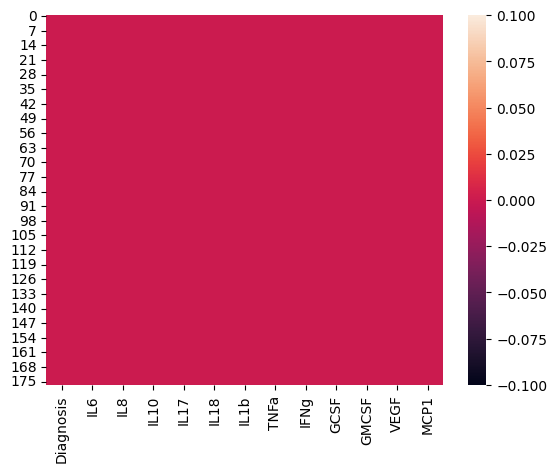

In [5]:
# Display information about missing values
sns.heatmap(data.isnull())

In [6]:
# Duplicate search
data.duplicated().any()

np.False_

In [7]:
# Division into attributes and target variable
X = data.drop(columns=['Diagnosis'])
y = data['Diagnosis']

In [8]:
# Separation into training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))
print('Diagnosis classes:', y_train.value_counts())

Train shape: (141, 12)
Test shape: (36, 12)
Diagnosis classes: Diagnosis
1    104
0     37
Name: count, dtype: int64


In [9]:
# Applying the SMOTE method for balancing classes
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print(y_train.value_counts())
print('Train shape: {}'.format(X_train.shape))

Diagnosis
1    104
0    104
Name: count, dtype: int64
Train shape: (208, 12)


In [10]:
# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Machine Learning models training

In [11]:
# Parameters for GridSearchCV
log_params = {'C': [0.001, 0.01, 0.1, 1, 3, 5, 10],
             'penalty': ['l1', 'l2']}

kNN_params = {'n_neighbors': range(3, 12, 2),
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']}

rf_params = {'n_estimators':[10,50,100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [None, 2, 3, 4, 5, 10],
             'min_samples_split': range(2, 6)}

tree_params = {'criterion' : ['gini', 'entropy'],
             'max_depth' : [None,2,3,4,5,10],
             'min_samples_split': range(2, 6)}

ada_params = {'n_estimators': [50, 100, 150, 200, 500],
              'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0]}

bag_params = {'n_estimators': [50, 100, 150, 200, 500],
              'max_samples': [0.5, 1.0]}

xgb_params = {'max_depth': [2, 3, 4, 5, 7],
              'learning_rate': [0.01, 0.1, 0.3],
              'n_estimators': [50, 100, 150, 200, 500],
              'reg_alpha': [0, 0.5, 1.0],
              'subsample': [0.8, 1.0],
              'colsample_bytree': [0.8, 1.0]}

GBDT_params = {'max_depth': [2, 3, 4, 5, 7],
              'learning_rate': [0.01, 0.05, 0.1],
              'n_estimators': [50, 100, 150, 200, 500],
               'subsample': [0.8, 1.0]}

# Grid searcg
logr = LogisticRegression()
log = GridSearchCV(LogisticRegression(), param_grid = log_params, scoring='roc_auc', cv = 3)
kNN = GridSearchCV(KNeighborsClassifier(), param_grid = kNN_params, scoring='roc_auc', cv = 3)
rf = GridSearchCV(RandomForestClassifier(), param_grid = rf_params, scoring='roc_auc', cv = 3)
tree = GridSearchCV(DecisionTreeClassifier(), param_grid = tree_params, scoring='roc_auc', cv = 3)
ada = GridSearchCV(AdaBoostClassifier(), param_grid = ada_params, scoring='roc_auc', cv = 3)
xgb = GridSearchCV(XGBClassifier(), param_grid = xgb_params, scoring='roc_auc', cv = 3)
bag = GridSearchCV(BaggingClassifier(), param_grid = bag_params, scoring='roc_auc', cv = 3)
GBDT = GridSearchCV(GradientBoostingClassifier(), param_grid = GBDT_params, scoring='roc_auc', cv = 3)

In [12]:
models = [log, kNN, tree, rf, ada, bag, xgb, GBDT]
model_names = ['log', 'kNN', 'tree', 'rf', 'ada', 'bag', 'XGB', 'GBDT']

for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    print(f"Better accuracy {name}: {model.best_score_}")
    print(f"The best hyperparameters: {model.best_params_}")

Better accuracy log: 0.5549179671868747
The best hyperparameters: {'C': 0.01, 'penalty': 'l2'}
Better accuracy kNN: 0.794781912765106
The best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Better accuracy tree: 0.8023849539815925
The best hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 4}
Better accuracy rf: 0.8818047218887554
The best hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Better accuracy ada: 0.774717887154862
The best hyperparameters: {'learning_rate': 1.0, 'n_estimators': 500}
Better accuracy bag: 0.8672749099639856
The best hyperparameters: {'max_samples': 1.0, 'n_estimators': 500}
Better accuracy XGB: 0.863001200480192
The best hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500, 'reg_alpha': 1.0, 'subsample': 0.8}
Better accuracy GBDT: 0.908971588635454
The best hyperparameters: {'learning_rate': 0

In [13]:
log = LogisticRegression(C=0.01, penalty='l2', solver='liblinear')
kNN = KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance')
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=5, random_state=1, class_weight='balanced')
rf = RandomForestClassifier(criterion='gini', max_depth=10, min_samples_split=2, n_estimators=100, random_state=1, class_weight='balanced')
ada = AdaBoostClassifier(estimator=tree, learning_rate=1.0, n_estimators=500, random_state=1)
bag = BaggingClassifier(estimator=tree, max_samples=1.0, n_estimators=500, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1)
xgb = XGBClassifier(estimator=tree, colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=500, reg_alpha=1.0, subsample=0.8, class_weight='balanced', eval_metric='logloss', use_label_encoder=True, random_state=1)
GBDT = GradientBoostingClassifier(learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.8, max_features='sqrt', random_state=1)

In [14]:
# Model training
log = log.fit(X_train, y_train)
kNN = kNN.fit(X_train, y_train)
tree = tree.fit(X_train, y_train)
rf = rf.fit(X_train, y_train)
ada = ada.fit(X_train, y_train)
bag = bag.fit(X_train, y_train)
xgb = xgb.fit(X_train, y_train)
GBDT = GBDT.fit(X_train, y_train)

In [15]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else [0]*len(y_test)

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba) if hasattr(model, "predict_proba") else None
    }
    return metrics

In [16]:
model_list = [kNN, tree, bag, ada, rf, log, xgb, GBDT]
model_name_list = ['kNN', 'tree', 'bag', 'ada', 'rf', 'log', 'xgb', 'GBDT']

# Collecting metrics in a dictionary list
metrics_list = []
for model, name in zip(model_list, model_name_list):
    metrics = evaluate_model(model, X_test, y_test)
    metrics['model'] = name
    metrics_list.append(metrics)

results_df = pd.DataFrame(metrics_list)

## Comparison of models by metrics

In [17]:
results_df = results_df.set_index('model')
results_df.sort_values(by='roc_auc', ascending=False, inplace=True)

results_df = results_df.round(2)
print(results_df)

       accuracy  precision  recall    f1  roc_auc
model                                            
xgb        0.81       0.83    0.92  0.87     0.82
rf         0.75       0.81    0.85  0.83     0.82
GBDT       0.81       0.83    0.92  0.87     0.81
bag        0.75       0.84    0.81  0.82     0.80
tree       0.69       0.86    0.69  0.77     0.71
log        0.58       0.87    0.50  0.63     0.69
ada        0.64       0.76    0.73  0.75     0.58
kNN        0.47       0.73    0.42  0.54     0.54


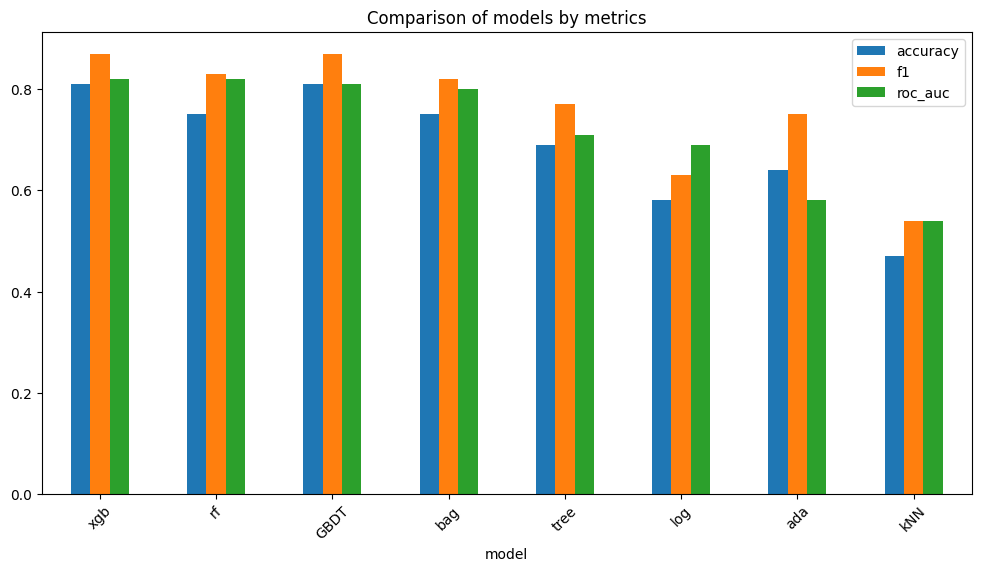

In [18]:
results_df.plot(kind='bar', y=['accuracy', 'f1', 'roc_auc'], figsize=(12, 6))
plt.title('Comparison of models by metrics')
plt.xticks(rotation=45)
plt.show()

## Roc Curve Display

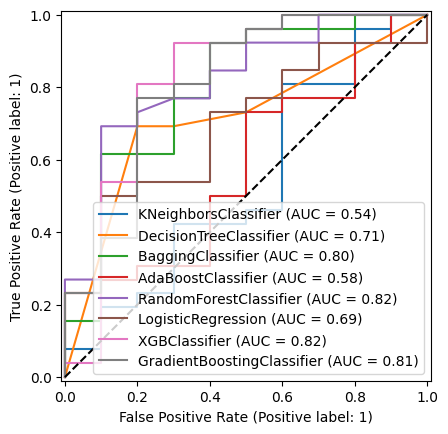

In [19]:
fig, ax = plt.subplots()

for model in model_list:
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]
    RocCurveDisplay.from_predictions(y_true=y_test, y_pred=y_test_pred_proba,
                                     name=model.__class__.__name__, ax=ax)
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

# Voting

In [20]:
model1 = xgb
model2 = rf
model3 = log

# Creating an ensemble
voting_clf = VotingClassifier(estimators=[('xgb', model1), ('rf', model2), ('log', model3)], voting='soft')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
y_proba = voting_clf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Precision:", precision_score(y_test, y_pred))
print("Recall_score:", recall_score(y_test, y_pred))
print("f1_score:", f1_score(y_test, y_pred))

Accuracy: 0.8055555555555556
ROC-AUC: 0.8423076923076923
Precision: 0.8518518518518519
Recall_score: 0.8846153846153846
f1_score: 0.8679245283018868


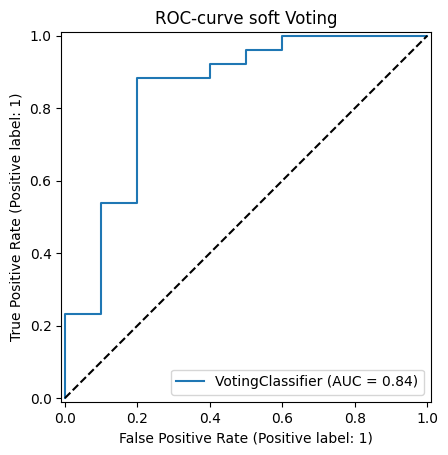

In [21]:
RocCurveDisplay.from_estimator(voting_clf, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC-curve soft Voting")
plt.show()

## Feature importances

<Axes: >

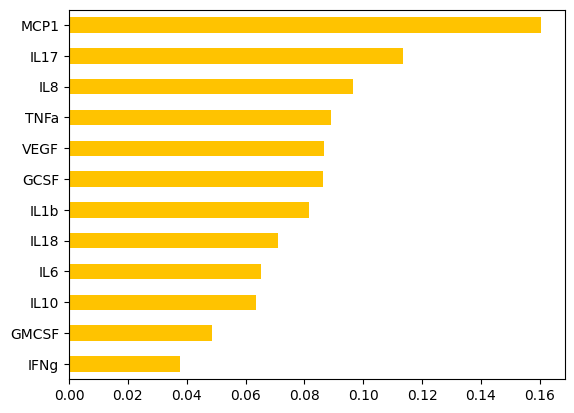

In [22]:
voting_clf.fit(X_train, y_train)
featuters = pd.Series(rf.feature_importances_, index=data.drop('Diagnosis', axis=1).columns)
featuters.sort_values(inplace=True)
featuters.plot.barh(color='#FFC300')